# HQNN-Quanv MedicalMNIST Local

- Model: HQNN-Quanv
- Dataset: MedicalMNIST
- Computer: local machine (lightning.qubit)


## Key notes on this model

- The ultimate goal of the model training is to find a **measurement basis** (by tweaking variational gate parameters) that tells us the most information about a fragment of a picture confined by the quantum kernel.
- Finally, for each wire, the expectation value of an **arbitrary operator** is calculated to obtain the classical output. As it is a real number, **it represents the kernel’s output pixel**, while each wire yields a **different image channel**. For instance, a quanvolutional kernel of size 2 × 2 has a 4-qubit circuit, which transforms one input image into _four images of reduced size_.


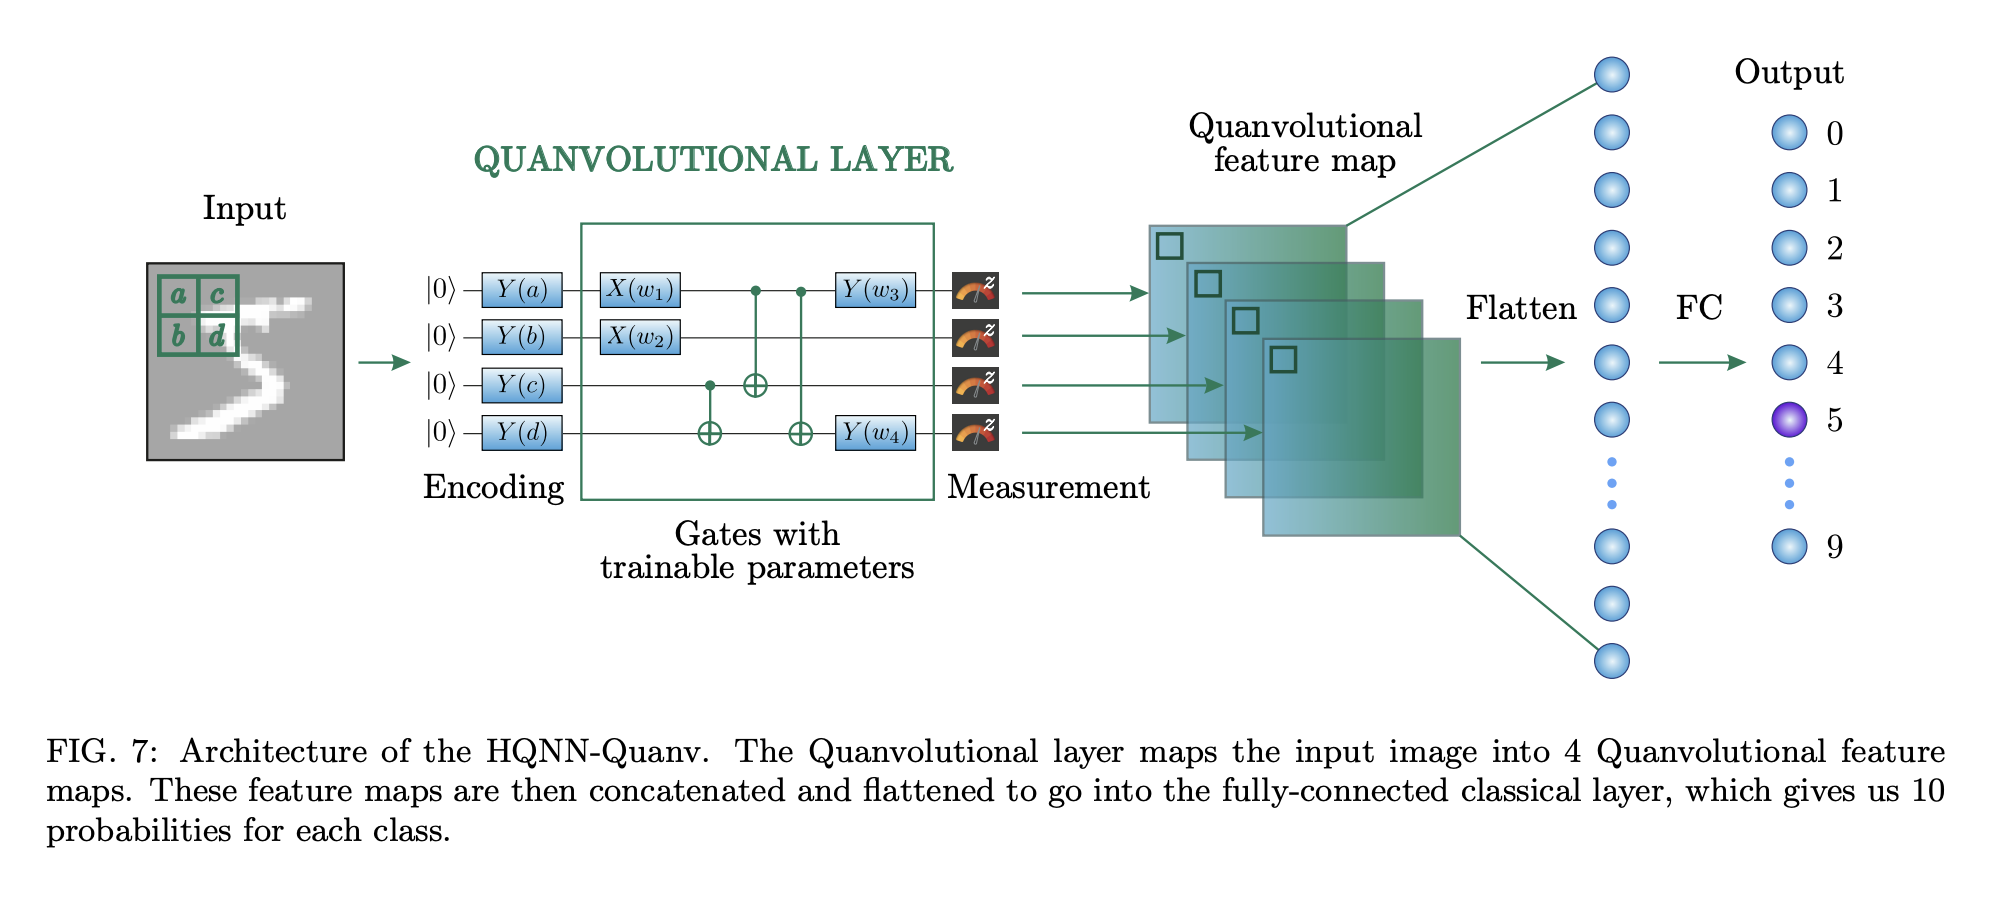


## Structure of the quantum kernel

First embed the pixels in the kernel to qubits, one qubit per pixel (2x2 kernel -> 4 qubits).

- This embedding will be done by first scaling the (0, 1) pixel value to (0, π) and then doing a Ry rotation by the scaled angle.

Then the variational circuit has 4 **parametrized** single-qubit rotations, and three CNOT gates (for the example of a 2x2 matrix)

Finally we measure the **expectation value** of the **Pauli-Z** operator for each qubit.

- This creates 4 output channels, each with one expectation value. "Each channel is a picture with 4 × 4 pixels." **what does this mean?**

The four output channels are then **flattened** and passed to a dense layer to generate probabilities for different classes.


In [1]:
# --- Import Model Components from Python File ---
import sys
from pathlib import Path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
from hqnn_quanv import HQNNQuanv
from utils import load_medical_mnist, train_model, save_model, predict_image, evaluate_model, load_model
import random

Quanvolutional Layer test passed.
HQNNQuanv Model test passed.


In [2]:
# --- Load and Preprocess MNIST Data ---
from torchvision import transforms

image_resize = 14

# Define the transformation to apply
transform = transforms.Compose([
    transforms.Resize((image_resize, image_resize)), # Resize images to 244x244
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset, test_dataset = load_medical_mnist(
    transform, 
    train_test_split=0.8, 
    dataset_portion=0.001
)

Path to Medical MNIST dataset files:  /Users/jaimanmunshi/.cache/kagglehub/datasets/andrewmvd/medical-mnist/versions/1
Total samples in Medical MNIST dataset: 58954
Using 47 samples for training and 11 samples for testing.


In [3]:
# --- Define Hyperparameters ---
hyperparams = {
    'image_size': image_resize,
    'kernel_size': 2,
    'depth': 1,
    'in_channels': 3,   # Medical MNIST is rgb images
    'n_classes': 6,     # 6 classes for Medical MNIST
    'epochs': 10,
    'learning_rate': 0.01,
    'batch_size': 32
}

--- Quantum Circuit Structure ---


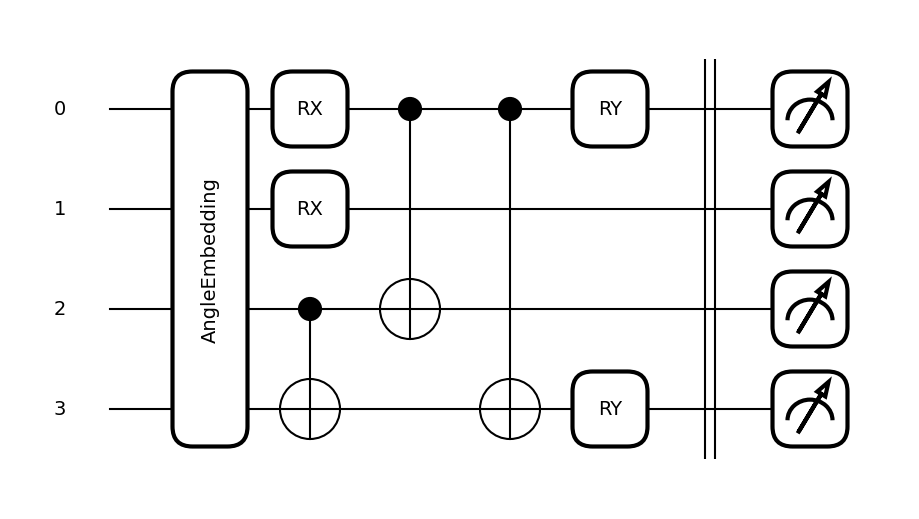

---------------------------------


In [4]:
# --- Initialize the Model ---
model = HQNNQuanv(
    draw_circuit=True,
    **hyperparams
)

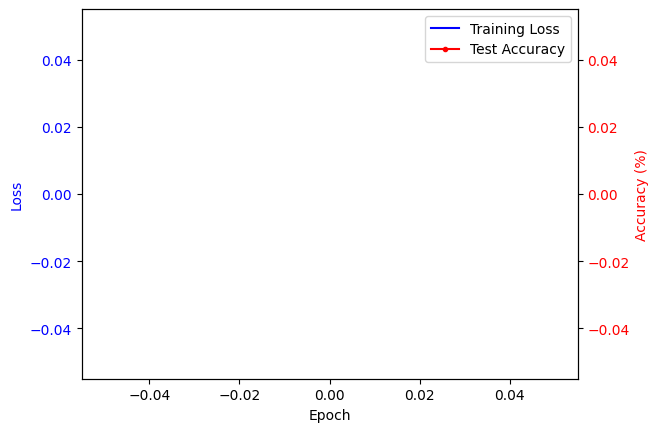

Starting training...
Training interrupted by user. Returning partial history...


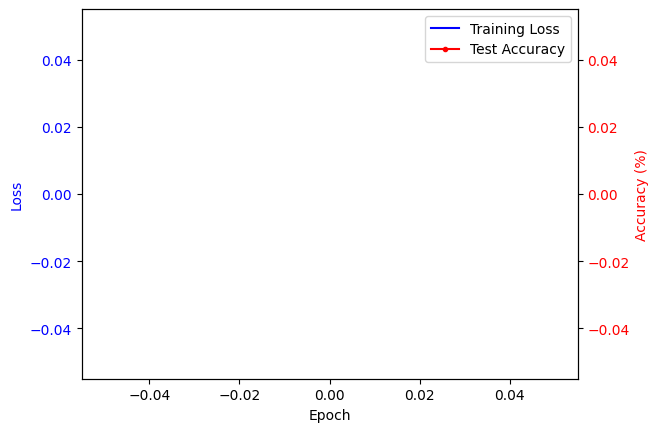

In [5]:
# -- Train the Model ---
history = train_model(
    model,
    train_dataset,
    test_dataset,
    plot=True,
    print_every_step=True,  # Because training is very very slow
    **hyperparams
)

In [7]:
# --- Save the Model ---
save_model(model, hyperparams, history, 'hqnn_quanv_medicalmnist_lightning')

Model saved to models/hqnn_quanv_medicalmnist_lightning/hqnn_quanv_medicalmnist_lightning_20250724_171421.pth


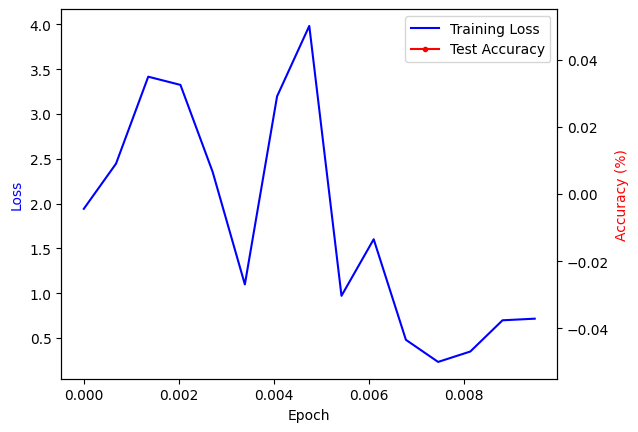

In [3]:
# Optionally load a saved model to evaluate
model = load_model(
    HQNNQuanv, 
    'models/hqnn_quanv_medicalmnist_lightning/hqnn_quanv_medicalmnist_lightning_20250724_171421.pth'
)

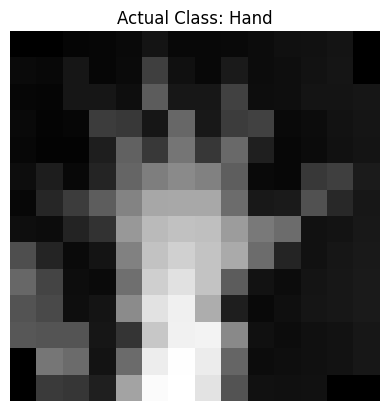

Class AbdomenCT : 0.1623
Class BreastMRI : 0.1194
Class CXR       : 0.0972
Class ChestCT   : 0.2698
Class Hand      : 0.2388
Class HeadCT    : 0.1125
Predicted Class: ChestCT, Confidence: 0.2698


In [6]:
# --- Run Model Prediction on Random Image ---
predict_image(model, test_dataset)

Evaluating Model:   0%|          | 0/11 [00:00<?, ?it/s]

Evaluating Model: 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

              precision    recall  f1-score   support

   AbdomenCT       0.33      1.00      0.50         1
   BreastMRI       0.00      0.00      0.00         2
         CXR       1.00      1.00      1.00         1
     ChestCT       0.00      0.00      0.00         1
        Hand       0.00      0.00      0.00         4
      HeadCT       0.00      0.00      0.00         2

    accuracy                           0.18        11
   macro avg       0.22      0.33      0.25        11
weighted avg       0.12      0.18      0.14        11



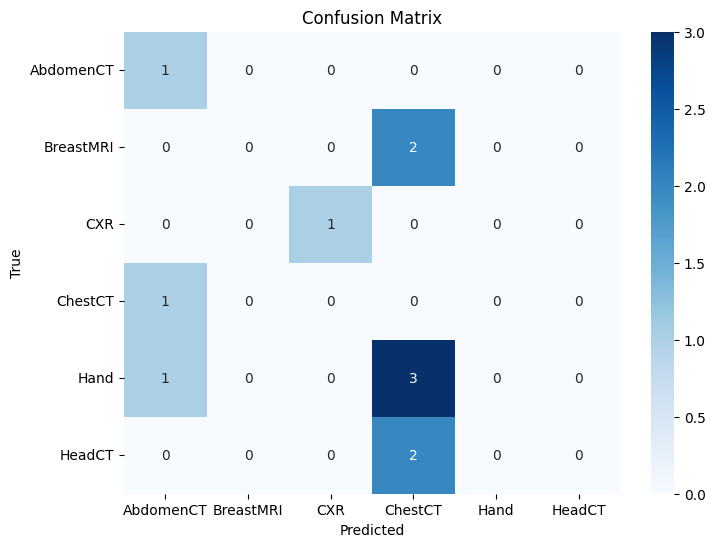

In [7]:
# --- Evaluate Model ---
test_accuracy = evaluate_model(model, test_dataset)